# Телеком
Оператор связи *«Ниединогоразрыва.ком»* хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

 **Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

 **Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [ ]:
from google.colab import drive
drive.mount('/gdrive.content')

Mounted at /gdrive.content


## 1. Предварительная обработка данных

### 1.1 Импорт библиотек, открытие файлов

In [ ]:
!pip install catboost
!pip install shap

     |████████████████████████████████| 76.1 MB 54 kB/s 
     |████████████████████████████████| 564 kB 3.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats as st
import time
from sklearn.utils import shuffle

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import shap

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier

In [ ]:
contract = pd.read_csv('/gdrive.content/MyDrive/projects/yandex/datasets/contract.csv')
personal = pd.read_csv('/gdrive.content/MyDrive/projects/yandex/datasets/personal.csv')
internet = pd.read_csv('/gdrive.content/MyDrive/projects/yandex/datasets/internet.csv')
phone = pd.read_csv('/gdrive.content/MyDrive/projects/yandex/datasets/phone.csv')

### 1.2 Получение основной информации о данных, поисе дубликатов и пропусков

In [ ]:
# Функция для просмотра всех колонок датасета
def view_data(data, qty=1, cols=None):
    df = data.copy()
    if cols:
        df = df[cols]
    columns = df.columns
    for i in range(0, len(columns), qty):
        display(df[columns[i: i + qty]])

In [ ]:
counter = 0
names = ['contract', 'personal', 'internet', 'phone']
for data in [contract, personal, internet, phone]:
    print()
    print(names[counter])
    print()
    print(f'Первые 5 строк датафрейма {names[counter]}:')
    print()
    display(data.head())
    print()
    print(f'Основная информация о датафрейме {names[counter]}:')
    print()
    print(data.info())
    print()
    print('Количество дубликатов: ', data.duplicated().sum())
    print()
    print('Количество уникальных значений в каждом столбце:')
    print({column:data[column].nunique() for column in data.columns})
    print(pd.DataFrame())
    
    counter += 1


contract

Первые 5 строк датафрейма contract:



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



Основная информация о датафрейме contract:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Количество дубликатов:  0

Количество уникальных значений в каждом столбце:
{'customerID': 7043, 'BeginDate': 77, 'EndDate': 5, 'Type': 3, 'PaperlessBilling': 2, 'PaymentMethod': 4, 'MonthlyCharges': 1585, 'TotalCharges': 6531}
Empty DataFrame
Columns: []
Index: []

personal

Первые 5 строк датафрейма personal:



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Основная информация о датафрейме personal:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

Количество дубликатов:  0

Количество уникальных значений в каждом столбце:
{'customerID': 7043, 'gender': 2, 'SeniorCitizen': 2, 'Partner': 2, 'Dependents': 2}
Empty DataFrame
Columns: []
Index: []

internet

Первые 5 строк датафрейма internet:



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Основная информация о датафрейме internet:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Количество дубликатов:  0

Количество уникальных значений в каждом столбце:
{'customerID': 5517, 'InternetService': 2, 'OnlineSecurity': 2, 'OnlineBackup': 2, 'DeviceProtection': 2, 'TechSupport': 2, 'StreamingTV': 2, 'StreamingMovies': 2}
Empty DataFrame
Columns: []
Index: []

phone

Первые 5 строк датафрейма phone:



,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Основная информация о датафрейме phone:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Количество дубликатов:  0

Количество уникальных значений в каждом столбце:
{'customerID': 6361, 'MultipleLines': 2}
Empty DataFrame
Columns: []
Index: []


В данных нет пропусков и дубликатов.

Описание данных:

**contract - информация о договоре**
* `customerID` - Уникальный идиентификатор пользователя;
* `BeginDate` - Дата заключения договора;
* `EndDate` - Дата окончания договора (если есть);
* `Type` - тип договора (помесячная оплпта, на 1 год или на 2 года);
* `PaperlessBilling` - Возможность получения электронного чека;
* `PaymentMethod` - способ расчета;
* `MonthlyCharges` - платежи в месяц;
* `TotalCharges` - итоговый платеж.

**personal - персональные данные клиента**
* `customerID` - Уникальный идиентификатор пользователя;
* `gender` - Пол клиента; 
* `SeniorCitizen` - является ли клиент пожилым;    
* `Partner` - семейное положение;         
* `Dependents` - наличие иждивенцев.

**internet - информация об интернет-услугах**
* `customerID` - Уникальный идиентификатор пользователя;          
* `InternetService` - тип подключения к интернету;
* `OnlineSecurity` - Интернет-безопасность: блокировка небезопасных сайтов;
* `OnlineBackup` - Облачное хранилище файлов для резервного копирования данных;       
* `DeviceProtection` - Интернет-безопасность: антивирус;   
* `TechSupport` -  Выделенная линия технической поддержки;       
* `StreamingTV`- Стриминговое телевидение;         
* `StreamingMovies` -  каталог фильмов;

**phone - информация об услугах телефонии**
* `customerID` - Уникальный идиентификатор пользователя;          
* `MultipleLines` - подключение к нескольким линиям одновременно.

      
 

### 1.3 Объединение датафреймов
длинна *contract* и *personal* одинакова. Если пользователи в ней одни и те же, то их можно объеденить.

In [ ]:
print('количество одинаковых пользователей в contract и personal:', 
      contract.query('customerID in @personal.customerID').shape[0]
     )

количество одинаковых пользователей в contract и personal: 7043


In [ ]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].replace(1, 'Yes')
personal['SeniorCitizen'] = personal['SeniorCitizen'].replace(0, 'No')
contract = contract.merge(personal)
del personal

В данных имеются записи о 7043 пользователях. Часть пользователей, пользуется только интернет услугами *«Ниединогоразрыва.ком»*, а часть только телефонными. У этих двух подмножеств есть пересечение - некоторые пользуюся всеми услугами. Соответсвенно средний чек отличается.

Проанализирую отдельно пользователей телефонии и интернета. Целевая переменная - это уйдет ли пользователь. Соответственно создам колонку со значением 1 - для тех пользователей, которые ушли и 0, которые к 01.02.2020 являются клиентами. А также посичтаю количество дней, в течение которых отказавшиеся клиенты пользовались сервисами. 

In [ ]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
print('самая ранняя запись: ', contract['BeginDate'].min())

самая ранняя запись:  2013-10-01 00:00:00


In [ ]:
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = np.NaN
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

Добавлю столбец *validaty* c количеством дней пользования услугами и столбец *target* со значением **1**, для клиентов, пользующихся сервисами к 01.02.2020 и со значением **0** для отказавшихся от услуг клиентов 

In [ ]:
latest_date = datetime.date(2020, 2, 1)

In [ ]:
contract['validaty'] = (
    ((contract['EndDate'] - contract['BeginDate']) / np.timedelta64(1, 'D'))
    .fillna((latest_date - contract['BeginDate'].dt.date) / np.timedelta64(1, 'D'))
    .astype('int')
    )

contract.loc[contract['EndDate'].isna(), 'target'] = 0
contract['target'] = contract['target'].fillna(1)

Тип данных у *TotalCharges* - object, хотя должен быть вещественным. Это из-за пустых строк.

In [ ]:
TotalCharges_empty = contract[contract['TotalCharges'].apply(lambda x: x.isspace())]
display(TotalCharges_empty.head())
print()
print('Количество объектов с пропущенными значениями TotalCharges: ', TotalCharges_empty.shape[0])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,validaty,target
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,,Female,No,Yes,Yes,0,0.0
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,,Male,No,No,Yes,0,0.0
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,,Female,No,Yes,Yes,0,0.0
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,,Male,No,Yes,Yes,0,0.0
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,,Female,No,Yes,Yes,0,0.0



Количество объектов с пропущенными значениями TotalCharges:  11


Таких строк 11 и это пользователи, которые пришли в конце рассматриваемого периода. Для обучения модели они не нужны и могут быть удалены.

In [ ]:
contract.drop(TotalCharges_empty.index, inplace=True)
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')

Для пользователей из *phone* добавлю столбец *phone*, чтобы при объединении данных, их можно было выделить.

In [ ]:
phone['phone'] = 'Yes'

In [ ]:
# Общий датафрейм
df = pd.merge(contract, phone, how='left')
df = df.merge(internet, how='left')

In [ ]:
del internet
del phone
del contract

In [ ]:
view_data(df.head(), 10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,No
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,No


,Partner,Dependents,validaty,target,MultipleLines,phone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection
0,Yes,No,31,0.0,NaN,NaN,DSL,No,Yes,No
1,No,No,1036,0.0,No,Yes,DSL,Yes,No,Yes
2,No,No,61,1.0,No,Yes,DSL,Yes,Yes,No
3,No,No,1371,0.0,NaN,NaN,DSL,Yes,No,Yes
4,No,No,61,1.0,No,Yes,Fiber optic,No,No,No


,TechSupport,StreamingTV,StreamingMovies
0,No,No,No
1,No,No,No
2,No,No,No
3,Yes,No,No
4,No,No,No


In [ ]:
df.shape

(7032, 23)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   object        
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  validaty          7032 non-null   int64         
 13  target            7032 non-null   float64       
 14  MultipleLines     6352 n

в новом датафреме появилось много пропусков. У пользователей, у которых был телефон, но не было интернета и у тех, у которых был интернет, но нет телефона. Для таких пользователей в столбцах с услугами проставлю *No*, а в столбце *InternetService* - *no_internet*.

In [ ]:
columns_to_fill_No = ['MultipleLines', 'OnlineSecurity', 'phone',
                      'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df[columns_to_fill_No] = df[columns_to_fill_No].fillna('No')
df['InternetService'] = df['InternetService'].fillna('no_interent')


In [ ]:
view_data(df.describe(include='all'), 8)

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7032,7032,1869,7032,7032,7032,7032.000000,7032.000000
unique,7032,76,4,3,2,4,NaN,NaN
top,7590-VHVEG,2014-02-01 00:00:00,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,NaN,NaN
freq,1,366,485,3875,4168,2365,NaN,NaN
first,NaN,2013-10-01 00:00:00,2019-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-01-01 00:00:00,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.798208,2283.300441
std,NaN,NaN,NaN,NaN,NaN,NaN,30.085974,2266.771362
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.587500,401.450000


,gender,SeniorCitizen,Partner,Dependents,validaty,target,MultipleLines,phone
count,7032,7032,7032,7032,7032.000000,7032.000000,7032,7032
unique,2,2,2,2,NaN,NaN,2,2
top,Male,No,No,No,NaN,NaN,No,Yes
freq,3549,5890,3639,4933,NaN,NaN,4065,6352
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,987.538538,0.265785,NaN,NaN
std,NaN,NaN,NaN,NaN,747.153663,0.441782,NaN,NaN
min,NaN,NaN,NaN,NaN,30.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,275.000000,0.000000,NaN,NaN


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,7032,7032,7032,7032,7032,7032,7032
unique,3,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,5017,4607,4614,4992,4329,4301
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.4 Выводы
В четырех файлах телеком компании хранится информация  о пользователях, их контрактах, а также потребляемых ими услугах интернета и телефонии. Для дальнейшего анализа целесообразно объединить данные и провести их первичную обработку. В качестве целевой переменной выступает информация ушел пользователь или нет, то есть имеет место задача бинарной классификации.

## Исследовательский анализ данных


Кто же те люди, которые отказались от услуг. По данным можно посмотреть, когда они отказывались и в течение какого периода они пользовались сервисами компании.

In [ ]:
leaved_user_count = df.groupby('EndDate').agg(count = ('EndDate', 'count'))
all_user_count = df.groupby('BeginDate').agg(count = ('BeginDate', 'count'))

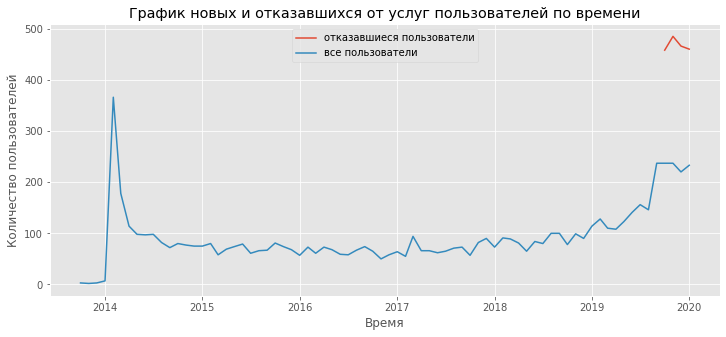

In [ ]:
fig, axes = plt.subplots(figsize=(12, 5))
axes.plot(leaved_user_count, label='отказавшиеся пользователи')
axes.plot(all_user_count, label='все пользователи')
axes.set_title('График новых и отказавшихся от услуг пользователей по времени')
axes.set_xlabel('Время')
axes.set_ylabel('Количество пользователей')
axes.legend(loc=9)
plt.grid(True)
plt.show()

Оказывается, отказывались всего в течение 4-х месяцев. Что это? может у конкурентов появился супер тариф или резко ухудшилось качество предоставляемых услуг? 

Надо взглянуть на отказавшихся пользователей отдельно

### Сравнение отказавшихся пользователей с оставшимися

In [ ]:
#df = df.drop('customerID', axis=1)
leaved_users = df[~df['EndDate'].isna()].drop(['BeginDate', 'EndDate', 'customerID'], axis=1)
remain_users = df[df['EndDate'].isna()].drop(['BeginDate', 'EndDate', 'customerID'], axis=1)
print(f'Количество ушедших пользователей: {leaved_users.shape[0]}')
print(f'Количество оставшихся пользователей: {remain_users.shape[0]}')

Количество ушедших пользователей: 1869
Количество оставшихся пользователей: 5163


In [ ]:
obj_features = df.columns[df.dtypes == 'object'] #категориальные
num_features = ['MonthlyCharges', 'TotalCharges', 'validaty'] #количественные

In [ ]:
leaved_users['validaty'].describe()

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: validaty, dtype: float64

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


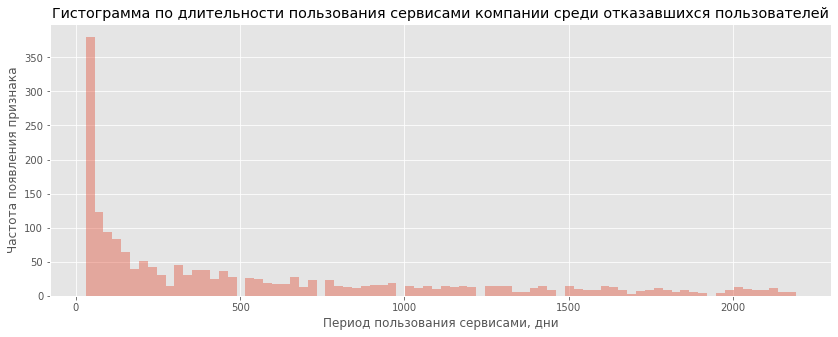

In [ ]:
plt.figure(figsize=(14, 5))
sns.distplot(leaved_users['validaty'], bins=80, kde=False)
plt.title('Гистограмма по длительности пользования сервисами компании среди отказавшихся пользователей')
plt.xlabel('Период пользования сервисами, дни')
plt.ylabel('Частота появления признака')
plt.grid(True)
plt.show()

50% клиентов пользовались сервисами не более 2-х месяцев. Этим людям мог не понравистя тариф или специально покупали услуги ненадолго.

Построю диаграммы типа *солнечные лучи* для отказавшихся и оставшихся пользователей. А также проверю гипотезы на влияние признаков на целевую переменную. Для категориальных переменных можно использовать тест Пирсона $\chi^2$. Тогда гипотезы:
* H0: признак не связан с уходом клиента;
* H1: признак связан с уходом клиента.

Если наблюдаемые частоты признака и целевой переменной похожи, то переменные независимы, данный признак не оказывает влияния на целевую переменную и может быть удален.

Пороговое значение *alpha* уровня статистической значимости выберу равным 0.05.

In [ ]:
# Функция для построения диаграммы
def create_3_lvl_labels(df, column):
    return list(df[column].value_counts().index + 
                ':' + ' ' + list(map(str, np.round_(100 * df[column].value_counts(normalize=True).values, 1))) + '%')
    
def create_3_lvl_parents(df, column, df_name):
    return len(df[column].value_counts()) * [df_name]

In [ ]:
alpha = 0.05 #Уровень значимости для проверки гипотез

# Колонки для проверки гипотез
columns_chi = ['Type', 'PaperlessBilling','PaymentMethod','gender','SeniorCitizen', 'Partner', 
                'Dependents',  'MultipleLines', 'phone', 'InternetService', 'OnlineSecurity',
                 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies']

In [ ]:
columns_to_drop = []
for column in columns_chi:
    
    df_chi = df[[column, 'target', 'customerID']].pivot_table(index=column, columns='target',  aggfunc='count')
    df_chi.columns = ['remain', 'leave']
    df_chi = df_chi.reset_index(drop=True)
    
    stat, p, dof, expected = st.chi2_contingency(df_chi[['remain', 'leave']])
    print()
    
    hyp = (f'По колонке "{column}":<br> p-значение: {p}.<br> Отвергаем нулевую гипотезу: признак связан с уходом клиента' 
          if p < alpha else 
           f'По колонке "{column}":<br> p-значение: {p}.<br>Не получилось опровергнуть нулевую гипотезу: признак не связан с уходом клиента')
    if p > alpha:
        columns_to_drop.append(column)
    
    # Sunbust
    labels = [column]
    parents = [""]
    values = [len(leaved_users[column]) + len(remain_users[column])]
    
    labels += list(['leaved_users', 'remain_users'])
    parents += list([column] * 2 )
    values +=  [len(leaved_users[column]), len(remain_users[column])]

    labels += list(create_3_lvl_labels(leaved_users, column)) + list(create_3_lvl_labels(remain_users, column))
    parents += (create_3_lvl_parents(leaved_users, column, 'leaved_users') + 
                    create_3_lvl_parents(remain_users, column, 'remain_users'))
    values += list(leaved_users[column].value_counts().values) + list(remain_users[column].value_counts().values)

    fig = go.Figure(go.Sunburst(
        labels = labels,
        parents = parents,
        values = values,
        branchvalues="total"
       ))
    fig.update_layout(
        title = hyp,
    
        margin = dict(t=110, l=0, r=0, b=0))
    fig.show()

In [ ]:
print('Признаки, которые не связаны с целевой переменной и могут быть удалены:', ', '.join(columns_to_drop))

Признаки, которые не связаны с целевой переменной и могут быть удалены: gender, phone


Теперь количественные признаки:

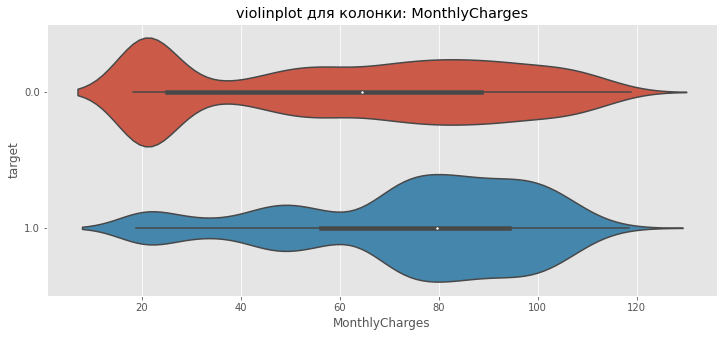

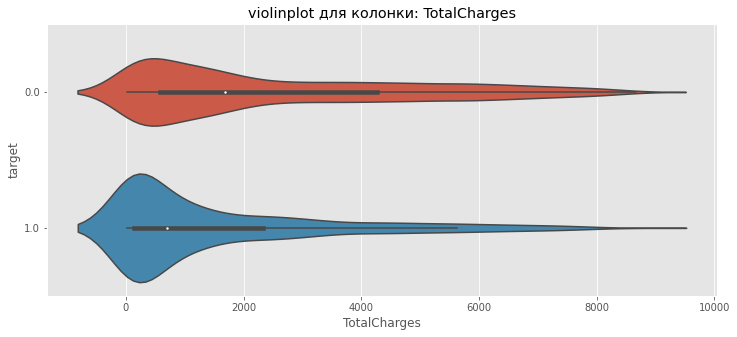

In [ ]:
for column in ['MonthlyCharges', 'TotalCharges']:
    plt.figure(figsize=(12,5))
    sns.violinplot(data=df, x=column, y='target', orient='h')
    plt.title(f'violinplot для колонки: {column}')
    plt.show()

Корреляция числовых признаков:

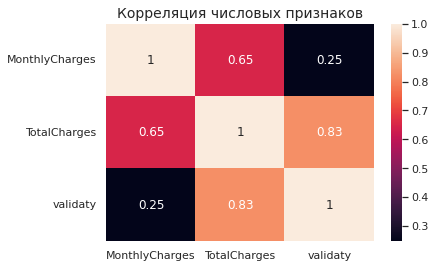

In [ ]:
plt.figure()
sns.set(font_scale=1)
sns.heatmap(df[num_features].corr(), annot=True)
plt.title('Корреляция числовых признаков', fontsize=14)
plt.show()

Сильная корреляция между числовыми признаками. Особенно между *TotalCharges* и *validaty*. Итоговый платеж зависит от количества дней пользования сервисами. Такая переменная избыточна и должна быть удалена.

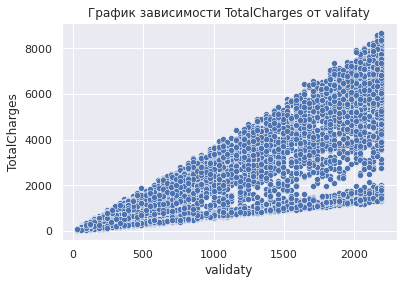

In [ ]:
plt.figure()
sns.scatterplot(data=df, x="validaty", y="TotalCharges")
plt.title('График зависимости TotalCharges от valifaty')
plt.show()

### Вывод
Период, в течение которого клиенты пользовались сервисом (*validaty*), может быть не совсем корректен. Часть пользователей отказались после нескольких месяцев использования. Но есть клиенты, которые подключились перед выгрузкой данных и теперь они *серые лошадки*. Они могут как уйти в течение нескольких месяцев, так и остаться. Однако в нашей выборке *validaty* для них одинаков. Скорее всего, именно в этих пользователей модель будет меньше всего уверена при классификации.

При анализе было рассмотрено две группы клиентов:
* *remain_users* - люди, которые пользуются сервисом на момент выгрузки данных;
* *leaved_users* - отказавшиеся от сервиса клиенты.

При этом из ушедших пользователей почти 70 % пользовались оптоволокном. Это наводит на мысль, что клиенты остались недовольны качествои или соотношением цена-качество для данной услуги. Также у ушедших клиентов доля пользовавшихся стриминговым ТВ и Медиатекой выше, чем у оставшихся. Возможно, что оптоволоконный интернет им нужен был как раз для этого. С помощью $\chi^2$ критерия было выявлено, что признаки *phone* и *gender* не вылияют на целевую переменную, поэтому могут быть удалены из данных. 

Ушедшие клиенты в основном платили от 80 у. е. до 100 в месяц, при том оставшиеся платят около 25 у. е.

Имеется линейная зависимость между признаками *TotalCharges* и *validaty*, поэтому *TotalCharges* также надо удалить.

## Подготовка данных к обучению модели

Для начало нужно удалить признаки, которые не нужны для обучения модели:
 * `EndDate` - по сути это и есть целевая переменная,
 * `BeginDate`, `CustomerID` - не нужна для обучения модели
 * `phone`, `gender`, `TotalCharges` - отсеянные признаки на этапе анализа.

In [ ]:
df_prep = df.copy()
df_prep = df_prep.drop(['customerID', 'BeginDate', 'EndDate', 'phone', 'gender', 'TotalCharges'], axis=1)

Часть  признаков принимают только 2 значения. Их можно закодировать 0 и 1 с помощью порядкового кодирования, остальные категориальные признаки закодирую с помощью ОНЕ.
Вещественные признаки отмасштабирую с помощью StandardScaler

In [ ]:
encoder = OrdinalEncoder()
columns_to_ord = df_prep.columns[(df_prep.dtypes == 'object').values * (df_prep.nunique() == 2).values]
df_prep[columns_to_ord] = pd.DataFrame(encoder.fit_transform(df_prep[columns_to_ord]), columns=columns_to_ord)
df_prep = pd.get_dummies(df_prep, drop_first=True)

In [ ]:
train, test = train_test_split(df_prep, test_size=0.15, random_state=12345, stratify=df_prep['target'])

In [ ]:
train.shape, test.shape

((5977, 21), (1055, 21))

In [ ]:
train['target'].value_counts(normalize=True)

0.0    0.734148
1.0    0.265852
Name: target, dtype: float64

In [ ]:
train_x, test_x = (train.drop('target', axis=1).reset_index(drop=True), test.drop('target', axis=1).reset_index(drop=True))
train_y, test_y = train['target'].reset_index(drop=True), test['target'].reset_index(drop=True)

In [ ]:
scaler = StandardScaler()
scaler.fit(train_x[['MonthlyCharges', 'validaty']])
train_x[['MonthlyCharges', 'validaty']] = scaler.transform(train_x[['MonthlyCharges', 'validaty']])
test_x[['MonthlyCharges', 'validaty']] = scaler.transform(test_x[['MonthlyCharges', 'validaty']])

In [ ]:
view_data(df_prep.head(), 10)

,PaperlessBilling,MonthlyCharges,SeniorCitizen,Partner,Dependents,validaty,target,MultipleLines,OnlineSecurity,OnlineBackup
0,1.0,29.85,0.0,1.0,0.0,31,0.0,0.0,0.0,1.0
1,0.0,56.95,0.0,0.0,0.0,1036,0.0,0.0,1.0,0.0
2,1.0,53.85,0.0,0.0,0.0,61,1.0,0.0,1.0,1.0
3,0.0,42.30,0.0,0.0,0.0,1371,0.0,0.0,1.0,0.0
4,1.0,70.70,0.0,0.0,0.0,61,1.0,0.0,0.0,0.0


,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic
0,0.0,0.0,0.0,0.0,0,0,0,1,0,0
1,1.0,0.0,0.0,0.0,1,0,0,0,1,0
2,0.0,0.0,0.0,0.0,0,0,0,0,1,0
3,1.0,1.0,0.0,0.0,1,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0,0,0,1,0,1


,InternetService_no_interent
0,0
1,0
2,0
3,0
4,0


Данные подготовлены к обучению:
 * Все категориальные переменные закодированы с помощью порядкового кодирования и ОНЕ;
 * Числовые переменные отмасштабтрованы;
 * Получены две выборки: обучающая и тестовая в соотношение 80% на 20% с использованием стратификации, так как целевая переменная несбалансирована (оставшихся клиентов больше, чем ушедших). Вадидационная не используется, так как будет применена кроссвалидация

## Обучение и тестирование моделей

Так как при обучении различных моделей многие действия повторяются, то есть смысл создать функцию.

In [ ]:
def train_model(model, params, train_x, train_y, test_x, test_y):
  toc = time.perf_counter()
  model.fit(train_x, train_y)
  tic = time.perf_counter()
  train_time = tic - toc

  toc = time.perf_counter()
  pred_y = model.predict(test_x)
  tic = time.perf_counter()
  pred_time = tic - toc

  accuracy = accuracy_score(test_y, pred_y)
  precision = precision_score(test_y, pred_y)
  recall = recall_score(test_y, pred_y)
  f1 = f1_score(test_y, pred_y)
  train_auc_score = model.best_score_
  test_auc_score = roc_auc_score(test_y, model.predict_proba(test_x)[:, 1])
  

  result = {'train_time' : train_time,
            'train_auc_score' : train_auc_score,
             'pred_time' : pred_time,
             'accuracy_score' : accuracy,
             'precision_score' : precision,
             'recall_score' : recall,
             'f1_score' : f1,
             'test_auc_score' : test_auc_score
      
  }
  
  return result

Для борьбы с дисбалансом можно попробовать технику увеличения выборки

In [ ]:
def upsample(features, target, repeat):
  
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled.reset_index(drop=True), target_upsampled.reset_index(drop=True)

### Модель логистической регресси

In [ ]:
model_reg = LogisticRegression(random_state=12345,  solver = 'liblinear')
penalty = ['l1', 'l2']
C = np.logspace(-4, 4, 50)
class_weight = [None, 'balanced']
params_reg = {'C': C, 
              'class_weight' : class_weight}

In [ ]:
rs_reg = RandomizedSearchCV(model_reg, params_reg, cv=5, n_iter=10, scoring = 'roc_auc')
model_reg_result = train_model(rs_reg, params_reg, train_x, train_y, test_x, test_y)
pd.Series(model_reg_result)

train_time         1.758105
train_auc_score    0.842355
pred_time          0.003821
accuracy_score     0.813270
precision_score    0.675105
recall_score       0.571429
f1_score           0.618956
test_auc_score     0.851947
dtype: float64

In [ ]:
print('Гиперпараметры для лучшей модели')
len([print('  ', keys, ':', values) for (keys,values) in rs_reg.best_params_.items()])

Гиперпараметры для лучшей модели
   class_weight : None
   C : 10000.0


2

**Использование техники увеличения выборки**

In [ ]:
train_x_upsampled, train_y_upsampled = upsample(train_x, train_y, 3)

In [ ]:
rs_reg_up = RandomizedSearchCV(model_reg, params_reg, cv=5, n_iter=10, scoring = 'roc_auc')
model_reg_up_result = train_model(rs_reg_up, params_reg, train_x_upsampled, train_y_upsampled, test_x, test_y)
pd.Series(model_reg_up_result)

train_time         2.223221
train_auc_score    0.843079
pred_time          0.003510
accuracy_score     0.766825
precision_score    0.539720
recall_score       0.825000
f1_score           0.652542
test_auc_score     0.851924
dtype: float64

In [ ]:
print('Гиперпараметры для лучшей модели')
len([print('  ', keys, ':', values) for (keys,values) in rs_reg_up.best_params_.items()])

Гиперпараметры для лучшей модели
   class_weight : balanced
   C : 2222.996482526191


2

Значение метрики *AUC-ROC* почти не изменилось, а вот значение метрики f1 выросло.

### Модель случайного леса

In [ ]:
model_forest = RandomForestClassifier()

n_estimators = [int(i) for i in np.linspace(start = 5, stop = 100, num = 20)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]
criterion = ['gini', 'entropy']

params_forest = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}



In [ ]:
rs_forest = RandomizedSearchCV(model_forest, params_forest, cv=5, n_iter=10, random_state=12345, scoring='roc_auc')

model_forest_result = train_model(rs_forest, params_reg, train_x, train_y, test_x, test_y)
pd.Series(model_forest_result)

train_time         14.070758
train_auc_score     0.857507
pred_time           0.024799
accuracy_score      0.817062
precision_score     0.718593
recall_score        0.510714
f1_score            0.597077
test_auc_score      0.863765
dtype: float64

In [ ]:
print('Гиперпараметры для лучшей модели: ')
len([print('  ', keys, ':', values) for (keys,values) in rs_forest.best_params_.items()])

Гиперпараметры для лучшей модели: 
   n_estimators : 95
   min_samples_split : 50
   min_samples_leaf : 6
   max_features : sqrt
   max_depth : 7
   criterion : entropy


6

**Использование техники увеличения выборки**

In [ ]:
rs_forest_up = RandomizedSearchCV(model_forest, params_forest, cv=5, n_iter=10, random_state=12345, scoring='roc_auc')

model_forest_up_result = train_model(rs_forest_up, params_reg, train_x_upsampled, train_y_upsampled, test_x, test_y)
pd.Series(model_forest_up_result)

train_time         17.962689
train_auc_score     0.941166
pred_time           0.026440
accuracy_score      0.778199
precision_score     0.561497
recall_score        0.750000
f1_score            0.642202
test_auc_score      0.859147
dtype: float64

In [ ]:
print('Гиперпараметры для лучшей модели: ')
len([print('  ', keys, ':', values) for (keys,values) in rs_forest_up.best_params_.items()])

Гиперпараметры для лучшей модели: 
   n_estimators : 70
   min_samples_split : 2
   min_samples_leaf : 1
   max_features : sqrt
   max_depth : 12
   criterion : entropy


6

### Catboost

In [ ]:
model_cat = CatBoostClassifier(verbose=False) 

In [ ]:
learning_rate = [0.01, 0.095, 1, 0.11, 0.09]
n_estimators = [800, 1000, 1200]
l2_leaf_reg = [20, 25, 27]
depth = [3, 5, 7]
border_count = [220, 240, 250, 260, 300]

loss_function = ['Logloss', 'CrossEntropy']
iterations = [600, 800, 1000]



params_cat = dict(learning_rate=learning_rate, l2_leaf_reg=l2_leaf_reg, iterations=iterations, depth=depth, border_count=border_count,
                  loss_function=loss_function)
    
params_cat

{'border_count': [220, 240, 250, 260, 300],
 'depth': [3, 5, 7],
 'iterations': [600, 800, 1000],
 'l2_leaf_reg': [20, 25, 27],
 'learning_rate': [0.01, 0.095, 1, 0.11, 0.09],
 'loss_function': ['Logloss', 'CrossEntropy']}

In [ ]:
rs_cat = RandomizedSearchCV(model_cat, params_cat, cv=5, n_iter=20, 
                            random_state=12345, scoring='roc_auc', verbose=0, n_jobs=-1, refit='roc_auc')

model_cat_result = train_model(rs_cat, params_cat, train_x, train_y, test_x, test_y)
pd.Series(model_cat_result)

train_time         270.811270
train_auc_score      0.923817
pred_time            0.003816
accuracy_score       0.883412
precision_score      0.839827
recall_score         0.692857
f1_score             0.759295
test_auc_score       0.921876
dtype: float64

In [ ]:
print('Гиперпараметры для лучшей модели: ')
len([print('  ', keys, ':', values) for (keys,values) in rs_cat.best_params_.items()])

Гиперпараметры для лучшей модели: 
   loss_function : Logloss
   learning_rate : 0.09
   l2_leaf_reg : 20
   iterations : 1000
   depth : 5
   border_count : 240


6

In [ ]:
result_index = ['Логистическая регрессия', 'Логистическая регрессия c увеличением выборки', 
                'Случайный лес', 'Случайный лес c увеличением выборки', 'Catboost']
result_columns = ['время на обучение модели. сек', 'auc-roc на обучающей выборке', 'время на предсказание модели, сек',
                  'доля правильных ответов', 'точность', 'полнота', 'f1-мера', 'auc-roc на тестовой выборке']
result_data = [model_reg_result, model_reg_up_result, model_forest_result, model_forest_up_result, model_cat_result]
result_table = pd.DataFrame(data=result_data, index=result_index)
result_table.columns = result_columns
result_table.drop('время на обучение модели. сек', axis=1)

,auc-roc на обучающей выборке,"время на предсказание модели, сек",доля правильных ответов,точность,полнота,f1-мера,auc-roc на тестовой выборке
Логистическая регрессия,0.842355,0.003821,0.813270,0.675105,0.571429,0.618956,0.851947
Логистическая регрессия c увеличением выборки,0.843079,0.003510,0.766825,0.539720,0.825000,0.652542,0.851924
Случайный лес,0.857507,0.024799,0.817062,0.718593,0.510714,0.597077,0.863765
Случайный лес c увеличением выборки,0.941166,0.026440,0.778199,0.561497,0.750000,0.642202,0.859147
Catboost,0.923817,0.003816,0.883412,0.839827,0.692857,0.759295,0.921876


### Вывод
Из обученных моделей лучший результат показала модель *Catboost*. значение метрики roc-auc получилось 0.921876. Использование техники увеличения выборки слабо помогло для метрики *auc-roc*, однако хорошо сказалось на f1-мере. 

## Анализ полученных результатов

Модель Catboost показала лучший результат. Для нее график важности произнаков с помощью библиотеки shap

In [ ]:
model_cat = CatBoostClassifier(border_count=rs_cat.best_params_['border_count'],
                               depth=rs_cat.best_params_['depth'],
                               iterations=rs_cat.best_params_['iterations'],
                               l2_leaf_reg=rs_cat.best_params_['l2_leaf_reg'],
                               learning_rate=rs_cat.best_params_['learning_rate'],
                               loss_function=rs_cat.best_params_['loss_function'],
                               random_state=12345,
                               verbose=False) 

model_cat.fit(train_x, train_y)
predictions_cat = model_cat.predict(test_x)
feature_importances = pd.Series(model_cat.feature_importances_, index=train_x.columns).sort_values()
print(feature_importances)

DeviceProtection                          0.599981
StreamingTV                               0.663050
OnlineBackup                              0.674396
Partner                                   0.713983
PaymentMethod_Credit card (automatic)     0.879265
Dependents                                0.912146
PaymentMethod_Mailed check                1.062877
OnlineSecurity                            1.224965
MultipleLines                             1.255657
StreamingMovies                           1.369033
SeniorCitizen                             1.524852
TechSupport                               1.696883
PaperlessBilling                          2.010013
Type_One year                             2.232488
PaymentMethod_Electronic check            2.338333
InternetService_no_interent               3.102382
Type_Two year                             5.111926
InternetService_Fiber optic               5.820544
MonthlyCharges                            9.947531
validaty                       

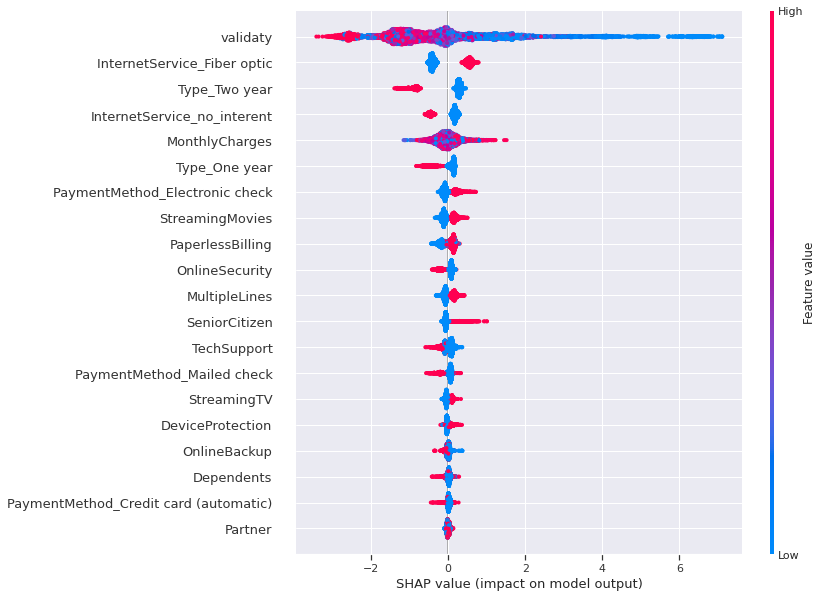

In [ ]:
shap_test = shap.TreeExplainer(model_cat).shap_values(train_x)
shap.summary_plot(shap_test, train_x, plot_size=(10,10))



Наибольшее влияние оказал признак *validaty*. Чем меньше пользователь являлся клиентом компании, тем большая вероятность его ухода.

ROC - кривая для модели CatBoost

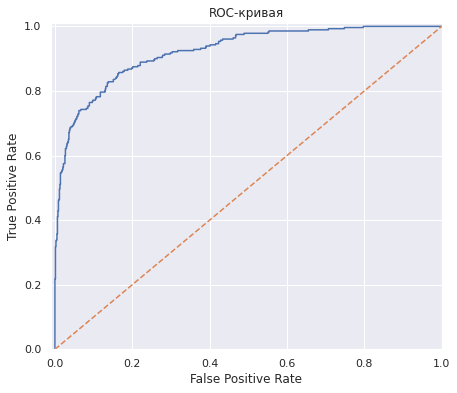

In [ ]:
probabilities_one_valid_cat = model_cat.predict_proba(test_x)[: , 1]
fpr, tpr, thresholds = roc_curve(test_y, probabilities_one_valid_cat)
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [ ]:
conf_matrix_cat = confusion_matrix(test_y, predictions_cat)

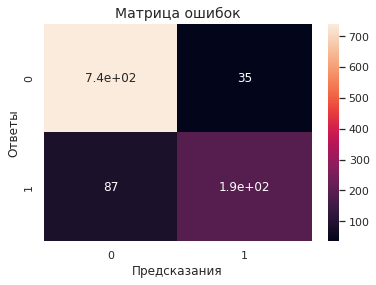

In [ ]:
plt.figure()
sns.set(font_scale=1)
sns.heatmap(conf_matrix_cat, annot=True)
plt.title('Матрица ошибок', fontsize=14)
plt.xlabel('Предсказания')
plt.ylabel('Ответы')
plt.show()

## Выводы

Для оператора связи *Ниединогоразрыва.ком* было проанализировано несколько моделей прогнозирования оттока клиентов. Наилучший результат по метрикам *roc-auc*, *f1-мера* и *accuracy* показала модель Catboost.

Компании стоит обратить внимание на цену и качество предоставления интернета по оптоволокну. Пользователи именно этой услуги наиболее часто отказываются от услуг.

Чтобы определить размер скидки, который предложить тем клиентам, уход которых спрогнозировала модель можно воспользоваться матрицей ошибок. Если модель машинного обучения верно предсказывает уход клиента, то компания может заработать на нем сумму, равную пожизненной ценности клиента (LVM) за вычетом предложенной скидки. В то же время, если модель спрогнозировала уход пользователя, а он решил остаться, то компания может потерять сумму в размере скидки. В обратном же случае, если компания не предложила скидку, а клиент отказался от услуг, то тут теряется сумма LVM-скидка. 

Чтобы оценить результат модели для компании можно провести А/В тест, где
* вариант А - скидки не раздаются, но при этом анализируется, уйдет ли клиент или останется;
* вариант В - скидки раздаются пользователям по прогнозу обученной модели. 

На основе этого теста можно расчитать размер скидки.

## Отчет по проекту

Проект составлен из следующих разделов:
* предварительная обработка данных - на аданном этапе были загружены основные библиотеки и 4 датасета, полученные от заказчика. Просмотрев данные и проверив их на пропуски и дубликаты (не оказалось) датасеты были объеденены в один, на котором и проводился исследовательский анализ. Целевая перемнная была выявлена по признаку - *EndDate*, в котором собрана информация о дате ухода клиента. На его базе, а также учитывая дату выгрузки логов был создан признак - *validaty*, означающий интервал времени, в течение которого пользователь являлся клиентом компании (*спойлер - данный признак оказался наиболее важным для модели).
* исследовательский анализ данных был произведен на основе объедененного датасета, в котором было 22 признака. В анализе была выполнена статистическая проверка гипотез для выявления признаков, оказывавших влияние на целевую переменную. Целевая переменная оказалась несбалансирована 73.5% оставшихся пользователей и 26.5% ушедших клиентов. После проверки было отсеяно несколько признаков. 
* Подготовка данных к обучению модели: на этом этапе, для оставшихся категориальных признаков, принимающих бмнарные значения было произведно порядковое кодирование, чтобы привести их к значениям 0 и 1. Количественные признаки, принимающие больше двух значений были закодированы с помощью техники ОНЕ. Чтобы не попасть в *dummy* ловушку, был применен *drop first* параметр. Чтобы количественные признаки не оказывали дополнительного влияния при обучении модели, они были отмасштабированы с помощью *StandardScaler* 
* По подготовленным данным было обучено несколько моделей (*logisticRegression*, *RandomForest* и *Catboost*). Для борьбы с дисбалансом была применена техника увеличения выборки. При этом рабочая метрика *auc-roc* не изменилась, но немного увеличилась метрика *f1*. Наилучшие результаты по *auc-roc* показала модель CatBoost - 0.921876, для которой и был произведен анализ важности признаков и построена матрица ошибок. По матрице ошибок было выявлено количество клиентов, на которых модель ошиблась (ошибки первого и второго рода). По этим данным была дана рекомендация, как оптимально попдойти к выбору размера скидки.